## Install latest PyTorch with CUDA

In [1]:
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117


In [1]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.version.cuda)

True
1
11.7


## Load Device

In [1]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np 
import math 

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## Load Dataset

### if using collab

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')
# images_dir = "/content/drive/MyDrive/IA/COVID-19_Radiography_Dataset/dataset_images/"
# masks_dir = "/content/drive/MyDrive/IA/COVID-19_Radiography_Dataset/dataset_masks/"

### if using local storage

In [2]:
images_dir = "./COVID-19_Radiography_Dataset/dataset_images/"
masks_dir = "./COVID-19_Radiography_Dataset/dataset_masks/"

### display images

In [3]:
def Show_imgs(imgs, name,  size = 3, color = True):
  color_m ='jet'
  if color == False:
    color_m ='gray'
  print('Label: ' + name) # can add a dict here
  img_numbers = imgs.shape[0]
  rows = cols = math.ceil(np.sqrt(img_numbers))
  
  fig = plt.figure(figsize=(rows*size, cols*size))
  for i in range(0, rows*cols):
    fig.add_subplot(rows, cols,i+1)
    if i<img_numbers:
      plt.imshow(imgs[i].detach(), cmap = 'gray')
  plt.show()

### custom dataset for storing images and masks together

In [4]:
class MaskedDataset(torch.utils.data.Dataset):
    def __init__(self, datasetA, datasetB):
        self.datasetA = datasetA
        self.datasetB = datasetB
        
    def __getitem__(self, index):
        xA = self.datasetA[index]
        xB = self.datasetB[index]
        return xA, xB
    
    def __len__(self):
        return len(self.datasetA)

### Distribution of each class

['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
COVID : 3616
Lung_Opacity : 6012
Normal : 10192
Viral Pneumonia : 1345


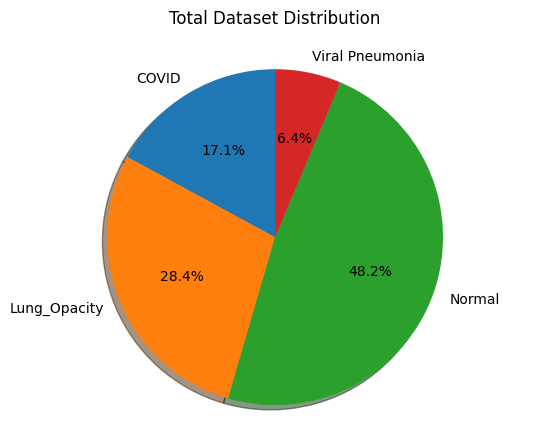

In [5]:
import matplotlib.pyplot as plt
import os
print(os.listdir(images_dir))
dir_list = []
dir_size = []
for dir in os.listdir(images_dir):
    cpt = sum([len(files) for r, d, files in os.walk(images_dir + "/" + dir)])
    dir_size.append(cpt)
    dir_list.append(dir)
    print(dir, ":", cpt)

fig1, ax1 = plt.subplots()
ax1.pie(dir_size,labels=dir_list, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.set_title("Total Dataset Distribution\n")
ax1.axis('equal')

plt.show()

### load dataset mantaining distributions

Loading Dataset...
Dataset ImageFolder
    Number of datapoints: 21165
    Root location: ./COVID-19_Radiography_Dataset/dataset_images/
    StandardTransform
Transform: Compose(
               RandomAdjustSharpness(sharpness_factor=20,p=1)
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
               Grayscale(num_output_channels=3)
               ToTensor()
           )
<class 'torchvision.datasets.folder.ImageFolder'>
{0: 'COVID', 1: 'Lung_Opacity', 2: 'Normal', 3: 'Viral Pneumonia'}
Loaded Dataset!
train set size: 14814
val set size: 4232
test set size: 2119
Label: Lung_Opacity


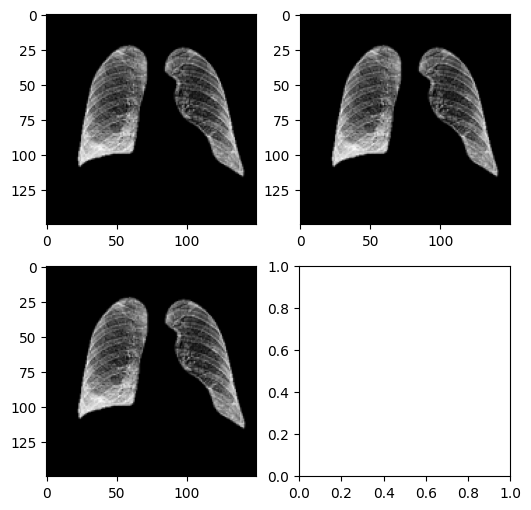

In [69]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import multiprocessing as mp
import numpy as np
import random

size = 150
use_from_total = 1
seed_ = 41
use_val = True
batch_size = 16

def load_dataset():
  #* apply sharpening, resize and transform to grayscale
  transform = transforms.Compose([transforms.RandomAdjustSharpness(20, p=1), 
                                  transforms.Resize((size, size)), 
                                  transforms.Grayscale(num_output_channels=3), # 1
                                  transforms.ToTensor()]) 

  #* load image and mask folders, print class dict
  print("Loading Dataset...")
  dataset = ImageFolder(root=images_dir, transform=transform)
  masks = ImageFolder(root=masks_dir, transform=transform)
  print(dataset)
  print(type(dataset))
  idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
  print(idx_to_class)
  print("Loaded Dataset!")

  #* generate indices
  COVID_idx = (np.arange(0, dir_size[0]))
  LUNG_OP_idx = (np.arange(dir_size[0], dir_size[0] + dir_size[1]))
  NORMAL_idx = (np.arange(dir_size[0] + dir_size[1], dir_size[0] + dir_size[1] + dir_size[2]))
  VIRAL_P_idx = (np.arange(dir_size[0] + dir_size[1] + dir_size[2], dir_size[0] + dir_size[1] + dir_size[2] + dir_size[3]))

  #* shuffle indexes and select use_from_total% from total indexes  
  COVID_idx = np.random.RandomState(seed=seed_).permutation(COVID_idx)[:int(use_from_total*len(COVID_idx))]
  LUNG_OP_idx = np.random.RandomState(seed=seed_).permutation(LUNG_OP_idx)[:int(use_from_total*len(LUNG_OP_idx))]
  NORMAL_idx = np.random.RandomState(seed=seed_).permutation(NORMAL_idx)[:int(use_from_total*len(NORMAL_idx))]
  VIRAL_P_idx = np.random.RandomState(seed=seed_).permutation(VIRAL_P_idx)[:int(use_from_total*len(VIRAL_P_idx))]

  #* select train/val/test using 70,20,10 or train/test using 70,30 
  train_indices = np.concatenate((COVID_idx[:int(0.7*len(COVID_idx))], 
                                  LUNG_OP_idx[:int(0.7*len(LUNG_OP_idx))],
                                  NORMAL_idx[:int(0.7*len(NORMAL_idx))],
                                  VIRAL_P_idx[:int(0.7*len(VIRAL_P_idx))]), axis=None)
  if use_val:
    val_indices =   np.concatenate((COVID_idx[int(0.7*len(COVID_idx)):int(0.90*len(COVID_idx))], 
                                    LUNG_OP_idx[int(0.7*len(LUNG_OP_idx)):int(0.90*len(LUNG_OP_idx))],
                                    NORMAL_idx[int(0.7*len(NORMAL_idx)):int(0.90*len(NORMAL_idx))],
                                    VIRAL_P_idx[int(0.7*len(VIRAL_P_idx)):int(0.90*len(VIRAL_P_idx))]), axis=None)
    test_indices =  np.concatenate((COVID_idx[int(0.90*len(COVID_idx)):], 
                                    LUNG_OP_idx[int(0.90*len(LUNG_OP_idx)):],
                                    NORMAL_idx[int(0.90*len(NORMAL_idx)):],
                                    VIRAL_P_idx[int(0.90*len(VIRAL_P_idx)):]), axis=None)
  else:
    val_indices =   np.array([-1])
    test_indices =  np.concatenate((COVID_idx[int(0.70*len(COVID_idx)):], 
                                    LUNG_OP_idx[int(0.70*len(LUNG_OP_idx)):],
                                    NORMAL_idx[int(0.70*len(NORMAL_idx)):],
                                    VIRAL_P_idx[int(0.70*len(VIRAL_P_idx)):]), axis=None) 

  #* final index shuffle (necesary)
  train_indices = np.random.RandomState(seed=seed_).permutation(train_indices)
  val_indices = np.random.RandomState(seed=seed_).permutation(val_indices)
  test_indices = np.random.RandomState(seed=seed_).permutation(test_indices)

  #* image and mask subsets based on permutated indexes
  train_set = torch.utils.data.Subset(dataset, train_indices)
  val_set = torch.utils.data.Subset(dataset, val_indices)
  test_set = torch.utils.data.Subset(dataset, test_indices)

  print("train set size:", len(train_set))
  print("val set size:", len(val_set))
  print("test set size:", len(test_set))

  train_set_mask = torch.utils.data.Subset(masks, train_indices)
  val_set_mask = torch.utils.data.Subset(masks, val_indices)
  test_set_mask = torch.utils.data.Subset(masks, test_indices)

  #* combined datasets of image and mask
  train_masked_set = MaskedDataset(train_set, train_set_mask)
  val_masked_set = MaskedDataset(val_set, val_set_mask)
  test_masked_set = MaskedDataset(test_set, test_set_mask)

  #* display a masked image
  (images, labels), (images_mask, _) = train_masked_set[0]
  Show_imgs((images*images_mask), idx_to_class[labels])

  #* dataloader generator with set seed
  def seed_worker(worker_id):
      worker_seed = torch.initial_seed() % 2**32
      np.random.seed(worker_seed)
      random.seed(worker_seed)

  g = torch.Generator()
  g.manual_seed(seed_)

  #* final data loaders 
  train_loader = DataLoader(dataset=train_masked_set, batch_size=batch_size, num_workers=0, pin_memory=True, shuffle=True, worker_init_fn=seed_worker, generator=g)
  val_loader = DataLoader(dataset=val_masked_set, batch_size=batch_size, num_workers=0, pin_memory=True, shuffle=True, worker_init_fn=seed_worker, generator=g) 
  test_loader = DataLoader(dataset=test_masked_set, batch_size=batch_size, num_workers=0, pin_memory=True, shuffle=True, worker_init_fn=seed_worker, generator=g) 

  # # test reproducibility, for debugging 
  # for ((_,label),(_,_)) in val_loader:
  #   print(label)

  return train_loader, val_loader, test_loader, idx_to_class

train_loader, val_loader, test_loader, idx_to_class = load_dataset()

### verify distribution is maintained

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

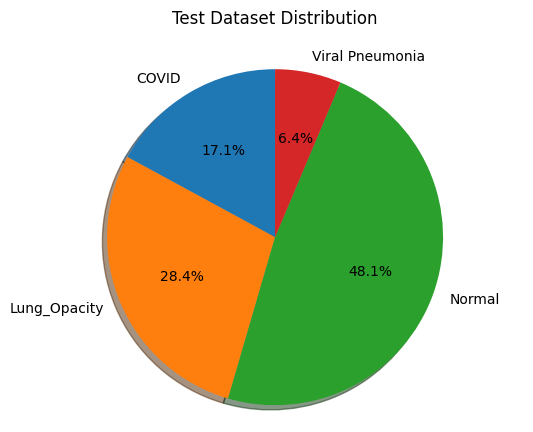

In [52]:
import numpy as np

test_labs = []
for ((_,label),(_,_)) in test_loader:
  print("|", end ="")
  test_labs.extend(label)

_, counts = np.unique(test_labs, return_counts=True)

fig1, ax1 = plt.subplots()
ax1.pie(counts,labels=dir_list, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.set_title("Test Dataset Distribution\n")
ax1.axis('equal')

plt.show()

## CNN Models

In [29]:
from torchvision import datasets, models

l1_c = 32  
l2_c = 64 

class CNN_Simple(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN_Simple, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3, out_channels=l1_c, kernel_size=7, stride=2, padding=3
            ),
            nn.ReLU(),
            # nn.BatchNorm2d(l1_c),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(
                in_channels=l1_c, out_channels=l2_c, kernel_size=5, stride=1, padding=2
            ),
            nn.ReLU(),
            # nn.BatchNorm2d(l2_c),
            nn.MaxPool2d(2, 2),
        )
        self.fc1 = nn.Sequential(nn.LazyLinear(32), nn.Linear(32,num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        return out

class CNN_Simple_BatchNorm(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN_Simple_BatchNorm, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3, out_channels=l1_c, kernel_size=7, stride=2, padding=3
            ),
            nn.BatchNorm2d(l1_c),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(
                in_channels=l1_c, out_channels=l2_c, kernel_size=5, stride=1, padding=2
            ),
            nn.BatchNorm2d(l2_c),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.fc1 = nn.Sequential(nn.LazyLinear(32), nn.Linear(32,num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        return out

class CNN_Simple_BatchNorm_Dropout(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN_Simple_BatchNorm_Dropout, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3, out_channels=l1_c, kernel_size=7, stride=2, padding=3
            ),
            nn.BatchNorm2d(l1_c),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(
                in_channels=l1_c, out_channels=l2_c, kernel_size=5, stride=1, padding=2
            ),
            nn.BatchNorm2d(l2_c),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.MaxPool2d(2, 2),
        )
        self.fc1 = nn.Sequential(nn.LazyLinear(32), nn.Linear(32,num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        return out

class CNN_Simple_BatchNorm_Dropout_First(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN_Simple_BatchNorm_Dropout_First, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3, out_channels=l1_c, kernel_size=7, stride=2, padding=3
            ),
            nn.BatchNorm2d(l1_c),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(
                in_channels=l1_c, out_channels=l2_c, kernel_size=5, stride=1, padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.fc1 = nn.Sequential(nn.LazyLinear(32), nn.Linear(32,num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        return out

def CNN_DenseNet(pretrained=True):
    model = models.densenet121(
        weights="IMAGENET1K_V1"
    )  # Densenet121 model pretrained on ImageNet1K
    num_ftrs = model.classifier.in_features  # densenet output
    print(num_ftrs)
    model.classifier = nn.Linear(num_ftrs, 4)  # fully connected output to num_classes
    model = model.to(device)  # send to gpu
    return model

## Pre cache data

In [16]:
# pre cache data from train loader
i=0
print(batch_size)
for ((images, labels), (images_mask, labels_mask)) in train_loader:
  print("|", end ="")
  i+=1

16
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

In [14]:
# pre cache data from val loader
i=0
for ((images, labels), (images_mask, labels_mask)) in val_loader:
  print("|", end ="")
  i+=1

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

In [15]:
# pre cache data from test loader
i=0
for ((images, labels), (images_mask, labels_mask)) in (test_loader):
  print("|", end ="")
  i+=1

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

## Train/Validation loop

### Train function

In [14]:
%matplotlib inline
import time
import pylab as pl
from IPython import display
import torch.nn.functional as F

model_path = "./model_checkpoint.pth"
early_stopped_at = 0
patience = 5
USE_MASKS = False
use_early_stopping = True

def train(model, optimizer, loss_fn, num_epochs):

  total_step = len(train_loader)
  print("total steps:", total_step)
  print("epochs:", num_epochs)

  #* Epoch loss history
  epoch_train_loss = []
  epoch_val_loss = []
  last_loss = 0
  last_vloss = 0

  #* Early stopping params
  best_score = None
  counter = 0
  global patience
  global early_stopped_at
  early_stopped_at = 0
  
  print("Training Starting...")

  for epoch in range(num_epochs):
    pl.clf()
    if epoch > 0: 
      print("last train loss:", last_loss, "last val loss:", last_vloss)

    last_loss = 0
    last_vloss = 0
    print("\nStarting epoch:", epoch+1)
    
    #* TRAINING
    len_loss = 0
    for i, ((images, labels), (images_mask, _)) in enumerate(train_loader):
      #* masks
      if USE_MASKS:
        masked_images = torch.mul(images, images_mask)
      else:
        masked_images = images

      #* to device
      masked_images = masked_images.to(device)
      labels = labels.to(device)

      #* forward
      output = model(masked_images)
      loss   = loss_fn(output, labels)
      
      #* change the params
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      #* add up loss
      last_loss += (loss.item())
      len_loss += 1
          
      if (i+1) % 100 == 0 or i == 0:
              print ('\nEpoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch+1, num_epochs, i+1, total_step, (last_loss)/(len_loss)))
      print("|", end ="")

    last_loss = (last_loss)/(len_loss)
    epoch_train_loss.append(last_loss)
    pl.plot(range(len(epoch_train_loss)), epoch_train_loss, label="train loss") 
    
    if use_val:
      #* VALIDATION
      with torch.no_grad():
        len_vloss = 0
        for i, ((vimages, vlabels), (vimages_mask, _)) in enumerate(val_loader):
          #* masks
          if USE_MASKS:
            vmasked_images = torch.mul(vimages, vimages_mask)
          else:
            vmasked_images = vimages 
          
          #* to device
          vmasked_images = vmasked_images.to(device)
          vlabels = vlabels.to(device)

          #* forward
          output = model(vmasked_images)
          vloss   = loss_fn(output, vlabels)
    
          #* add up loss
          last_vloss += (vloss.item())
          len_vloss += 1

          if (i+1) % 100 == 0 or i == 0:
                  print ('\nVal Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                        .format(epoch+1, num_epochs, i+1, len(val_loader), (last_vloss)/(len_vloss)))
          print("|", end ="")

      last_vloss = (last_vloss)/(len_vloss)
      epoch_val_loss.append(last_vloss)
      pl.plot(range(len(epoch_val_loss)), epoch_val_loss, label="validation loss")

      #* Early stopping
      if use_early_stopping:
        if best_score is None:
          best_score = last_vloss
        else:
            # Check if val_loss improves or not.
            if last_vloss < best_score:
                # val_loss improves, we update the latest best_score, 
                # and save the current model
                best_score = last_vloss
                torch.save({'state_dict':model.state_dict()}, model_path)
            else:
                # val_loss does not improve, we increase the counter, 
                # stop training if it exceeds the amount of patience
                counter += 1
                if counter >= patience:
                  print("\tEarly Stopped")
                  early_stopped_at = epoch + 1
                  break

    pl.xlabel('epochs')
    pl.ylabel('loss')
    pl.title("Loss over Iteration")
    pl.legend(loc="upper right")
    display.clear_output(wait=True) 
    display.display(pl.gcf())
    time.sleep(1.0)
    plt.close()
  
  print('\nFinished Training Trainset')
  print("last train loss:", last_loss, "last val loss:", last_vloss)
  
  # Load best model 
  if use_early_stopping: # if use_val
    if num_epochs != 0:
      print('loading best model before testing.')
      model_checkpoint = torch.load(model_path)
      model.load_state_dict(model_checkpoint['state_dict'])
    
  return epoch_train_loss, epoch_val_loss


## Calculate Accuracy

In [63]:
aac = 0
def test_accuracy(selected_model):
  test_labs = []
  pred_labs = []

  print('\n Calculating current model accuracy')
  with torch.no_grad():
    correct = 0
    total = 0
    for i, ((images, labels), (images_mask, _)) in enumerate(test_loader):
      #* masks
      if USE_MASKS:
        masked_images = torch.mul(images, images_mask)
      else:
        masked_images = images
      
      #* to device
      masked_images = masked_images.to(device)
      labels = labels.to(device)

      #* calc output
      outputs = selected_model(masked_images)
      _, predicted = torch.max(outputs.data, 1)
      
      #* add up accuracy
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      print("|", end ="")
      
      test_labs.extend(labels.tolist())
      pred_labs.extend(predicted.tolist())

    print('\nTest Accuracy of the model: {} %'.format(100 * correct / total))
    aac = 100 * correct / total
    return aac, test_labs, pred_labs

## Visualize confusion matrix

In [103]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_cnf_matrix(Y_test, Y_pred):
  time.sleep(1.0)
  cnf_matrix = confusion_matrix(Y_test, Y_pred)
  
  cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]

  ax= plt.subplot()
  sns.heatmap(cnf_matrix, annot=True, fmt='.2f', ax=ax);  
  
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
  ax.xaxis.set_ticklabels(list(idx_to_class.values())); ax.yaxis.set_ticklabels( list(idx_to_class.values()));
  ax.set_title('Confusion Matrix'); 
  plt.show()

## Write last model state and results

### save figure as png

In [17]:
def save_fig(filename_, epoch_train_loss_, epoch_val_loss_):
  plt.clf()
  plt.plot(range(len(epoch_train_loss_)), epoch_train_loss_, label="train loss")
  if use_val:
    plt.plot(range(len(epoch_val_loss_)), epoch_val_loss_, label="validation loss")
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.title("Loss over Iteration")
  plt.legend(loc="upper right")
  plt.savefig(filename_)

### write model state to file, and hyperparameters to txt

In [18]:
def write_results(selected_model, epoch_train_loss_, epoch_val_loss_, name = "model"):
  filename = f"./models/{name}_results_"
  filename_m = f"./models/{name}_"

  i = 0
  while os.path.exists(f"{filename}{i}.txt"):
    i += 1
  print("\nwriting results to " + f"{filename}{i}.txt" + " and model to " + f"{filename_m}{i}.pth")
  with open(f"{filename}{i}.txt", 'w') as output:
    output.write("Hyperparameters:" + "\n") 
    output.write("accuracy : " + str(aac) + "\n") 
    output.write("use_early_stopping : " + str(use_early_stopping) + "\n") 
    output.write("early_stopped_at : " + str(early_stopped_at) + "\n") 
    output.write("num_epochs : " + str(num_epochs) + "\n") 
    output.write("USE_MASKS : " + str(USE_MASKS) + "\n") 
    output.write("img_size : " + str(size) + "\n") 
    output.write("use_from_total : " + str(use_from_total) + "\n") 
    output.write("use_val : " + str(use_val) + "\n") 
    
    
    output.write("weight_decay : " + str(weight_decay_) + "\n") 
    output.write("learning_rate : " + str(learning_rate) + "\n") 
    output.write("patience : " + str(patience) + "\n") 
    output.write("seed : " + str(seed_) + "\n") 
    output.write("----------------------------" + "\n") 
    output.write("Model Layers:\n" + str(selected_model) + "\n") 

  torch.save({'state_dict':selected_model.state_dict()}, f"{filename_m}{i}.pth")

  save_fig( f"{filename}{i}.png", epoch_train_loss_, epoch_val_loss_)  

## SimpleCNN Models

### 0) Simple CNN no mask, no early stopping, 85.7% accuracy

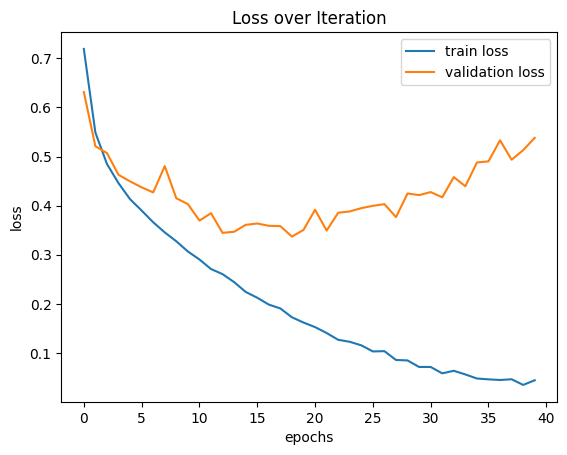


Finished Training Trainset
last train loss: 0.044371401908775775 last val loss: 0.5380817151399997

 Calculating current model accuracy
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Test Accuracy of the model: 85.70080226521944 %

writing results to ./models/SimpleCNN_results_0.txt and model to ./models/SimpleCNN_0.pth


In [105]:
#* hyperparameters
size = 150
batch_size = 16
num_classes = 4
use_from_total = 1
seed_ = 41
USE_MASKS = False
patience = 5
use_val = True
use_early_stopping = False
learning_rate = 0.0001 
weight_decay_ = 0.001
num_epochs = 40

model = CNN_Simple(num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay_)

train_loader, val_loader, test_loader, idx_to_class = load_dataset()

epoch_train_loss, epoch_val_loss = train(model,optimizer,loss_fn,num_epochs)
aac,_,_ = test_accuracy(model)
write_results(model, epoch_train_loss, epoch_val_loss, name="SimpleCNN")

### 1) Simple CNN no mask, val - 87.1% accuracy

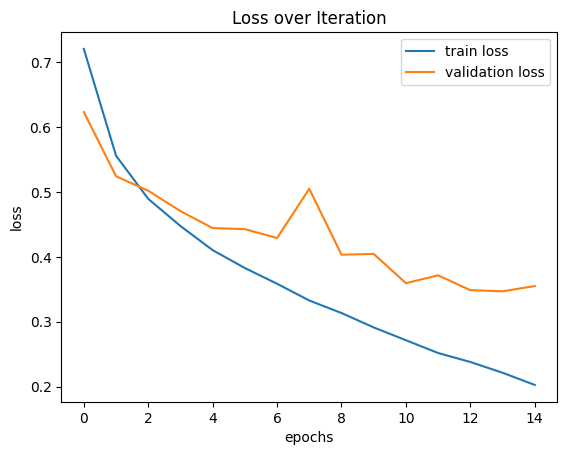

last train loss: 0.20251407926262519 last val loss: 0.3550161919011822

Starting epoch: 16

Epoch [16/40], Step [1/926], Loss: 0.2872
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Epoch [16/40], Step [100/926], Loss: 0.1822
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Epoch [16/40], Step [200/926], Loss: 0.1761
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Epoch [16/40], Step [300/926], Loss: 0.1821
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Epoch [16/40], Step [400/926], Loss: 0.1820
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Epoch [16/40], Step [500/926], Loss: 0.1893
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Epoch [16/40], Step [600/926], Loss: 0.18

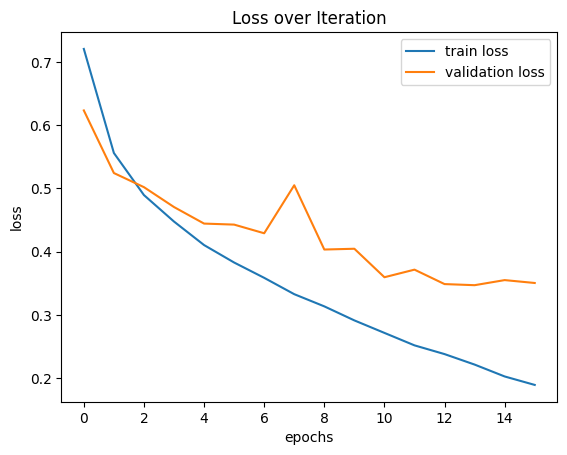

In [55]:
#* hyperparameters
size = 150
batch_size = 16
num_classes = 4
use_from_total = 1
seed_ = 41
USE_MASKS = False
patience = 5
use_val = True
use_early_stopping = True
learning_rate = 0.0001 
weight_decay_ = 0.001
num_epochs = 40

model = CNN_Simple(num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay_)

train_loader, val_loader, test_loader, idx_to_class = load_dataset()

epoch_train_loss, epoch_val_loss = train(model,optimizer,loss_fn,num_epochs)
aac,_,_ = test_accuracy(model)
write_results(model, epoch_train_loss, epoch_val_loss, name="SimpleCNN")

### 2) Simple CNN mask, val - 81.1% accuracy

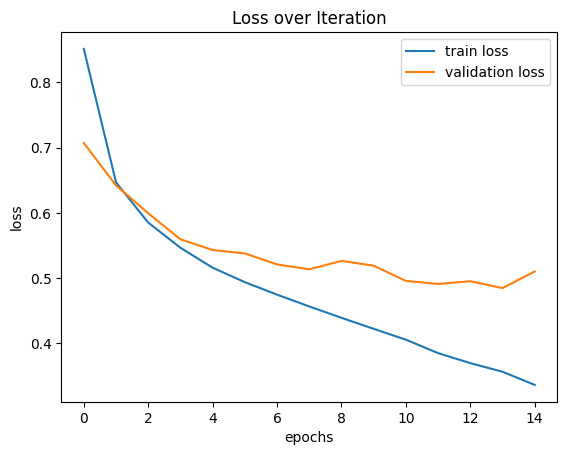

last train loss: 0.33620320036846413 last val loss: 0.510076224410309

Starting epoch: 16

Epoch [16/40], Step [1/926], Loss: 0.4762
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Epoch [16/40], Step [100/926], Loss: 0.2955
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Epoch [16/40], Step [200/926], Loss: 0.2933
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Epoch [16/40], Step [300/926], Loss: 0.3065
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Epoch [16/40], Step [400/926], Loss: 0.3087
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Epoch [16/40], Step [500/926], Loss: 0.3160
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Epoch [16/40], Step [600/926], Loss: 0.317

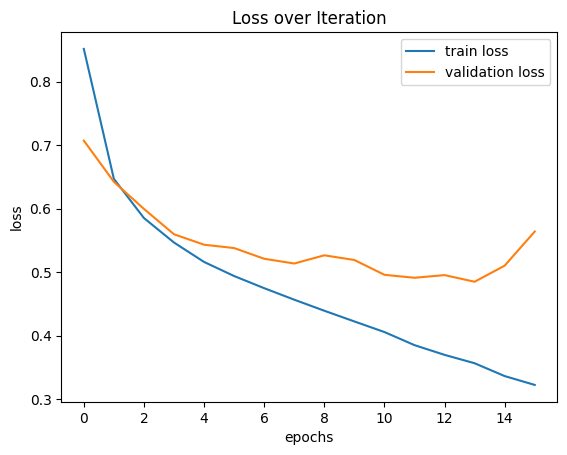

In [56]:
#* hyperparameters
size = 150
batch_size = 16
num_classes = 4
use_from_total = 1
seed_ = 41
USE_MASKS = True
patience = 5
use_val = True
use_early_stopping = True
learning_rate = 0.0001 
weight_decay_ = 0.001
num_epochs = 40

model = CNN_Simple(num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay_)

train_loader, val_loader, test_loader, idx_to_class = load_dataset()

epoch_train_loss, epoch_val_loss = train(model,optimizer,loss_fn,num_epochs)
aac,_,_ = test_accuracy(model)
write_results(model, epoch_train_loss, epoch_val_loss, name="SimpleCNN")

## Batch / Dropout Models

### 3) Simple CNN no mask, val, batchnorm all layers - 85.7% accuracy

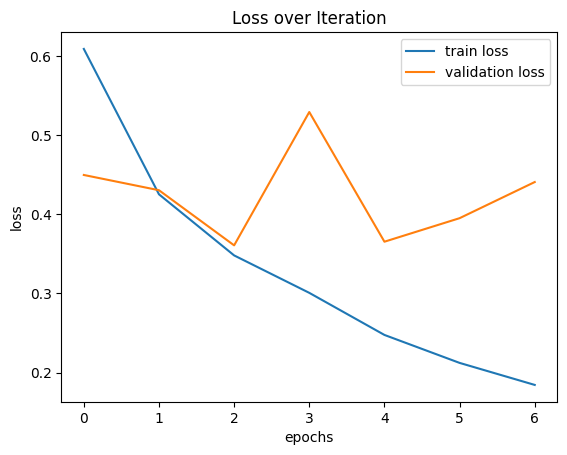

last train loss: 0.18430102248042501 last val loss: 0.4407876282860086

Starting epoch: 8

Epoch [8/40], Step [1/926], Loss: 0.1427
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Epoch [8/40], Step [100/926], Loss: 0.1507
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Epoch [8/40], Step [200/926], Loss: 0.1362
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Epoch [8/40], Step [300/926], Loss: 0.1317
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Epoch [8/40], Step [400/926], Loss: 0.1330
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Epoch [8/40], Step [500/926], Loss: 0.1355
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Epoch [8/40], Step [600/926], Loss: 0.1417
|||||

In [117]:
#* hyperparameters
size = 150
batch_size = 16
num_classes = 4
use_from_total = 1
seed_ = 41
USE_MASKS = False
patience = 5
use_val = True
use_early_stopping = True
learning_rate = 0.0001 
weight_decay_ = 0.001
num_epochs = 40

model = CNN_Simple_BatchNorm(num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay_)

train_loader, val_loader, test_loader, idx_to_class = load_dataset()

epoch_train_loss, epoch_val_loss = train(model,optimizer,loss_fn,num_epochs)
aac,_,_ = test_accuracy(model)
write_results(model, epoch_train_loss, epoch_val_loss, name="SimpleCNN_BatchNorm")

### 4) Simple CNN no mask, val, batchnorm + dropout(50%) all layers - 87.1% accuracy

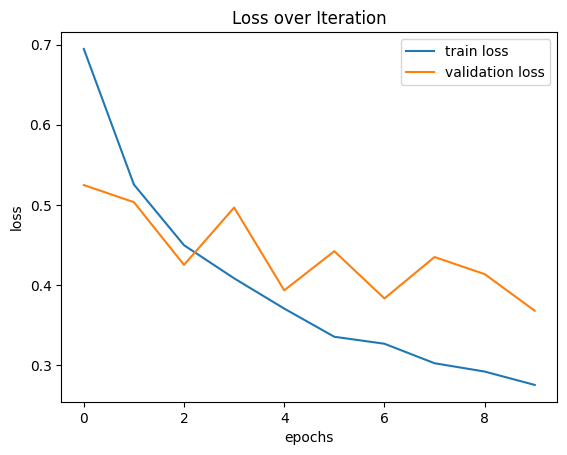

last train loss: 0.27505044314253985 last val loss: 0.367720734166368

Starting epoch: 11

Epoch [11/40], Step [1/926], Loss: 0.0988
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Epoch [11/40], Step [100/926], Loss: 0.2418
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Epoch [11/40], Step [200/926], Loss: 0.2536
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Epoch [11/40], Step [300/926], Loss: 0.2702
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Epoch [11/40], Step [400/926], Loss: 0.2657
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Epoch [11/40], Step [500/926], Loss: 0.2674
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Epoch [11/40], Step [600/926], Loss: 0.265

In [118]:
#* hyperparameters
size = 150
batch_size = 16
num_classes = 4
use_from_total = 1
seed_ = 41
USE_MASKS = False
patience = 5
use_val = True
use_early_stopping = True
learning_rate = 0.0001 
weight_decay_ = 0.001
num_epochs = 40

model = CNN_Simple_BatchNorm_Dropout(num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay_)

train_loader, val_loader, test_loader, idx_to_class = load_dataset()

epoch_train_loss, epoch_val_loss = train(model,optimizer,loss_fn,num_epochs)
aac,_,_ = test_accuracy(model)
write_results(model, epoch_train_loss, epoch_val_loss, name="SimpleCNN_BatchNorm_Dropout")

### 5) Simple CNN no mask, val, batchnorm + dropout(50%) first layer - 85.9% accuracy

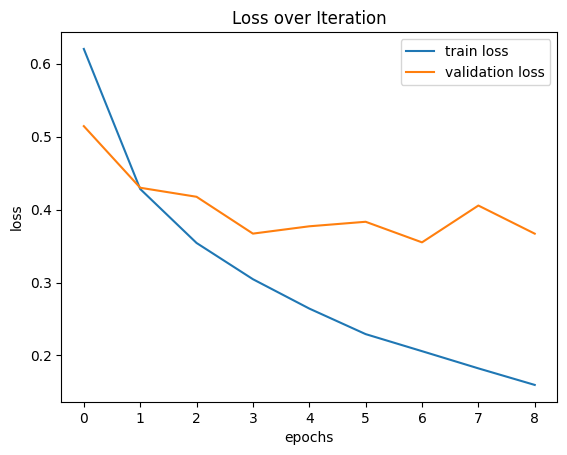

last train loss: 0.15964608866878288 last val loss: 0.3669574249008635

Starting epoch: 10

Epoch [10/40], Step [1/926], Loss: 0.0318
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Epoch [10/40], Step [100/926], Loss: 0.1163
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Epoch [10/40], Step [200/926], Loss: 0.1320
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Epoch [10/40], Step [300/926], Loss: 0.1377
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Epoch [10/40], Step [400/926], Loss: 0.1451
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Epoch [10/40], Step [500/926], Loss: 0.1410
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Epoch [10/40], Step [600/926], Loss: 0.14

In [119]:
#* hyperparameters
size = 150
batch_size = 16
num_classes = 4
use_from_total = 1
seed_ = 41
USE_MASKS = False
patience = 5
use_val = True
use_early_stopping = True
learning_rate = 0.0001 
weight_decay_ = 0.001
num_epochs = 40

model = CNN_Simple_BatchNorm_Dropout_First(num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay_)

train_loader, val_loader, test_loader, idx_to_class = load_dataset()

epoch_train_loss, epoch_val_loss = train(model,optimizer,loss_fn,num_epochs)
aac,_,_ = test_accuracy(model)
write_results(model, epoch_train_loss, epoch_val_loss, name="SimpleCNN_BatchNorm_Dropout_First")

## Densenet121 Models

### 6) Model densenet121, no mask, val - 93.6% accuracy

In [ ]:
#* hyperparameters
size = 150
batch_size = 16
num_classes = 4
use_from_total = 1
seed_ = 41
USE_MASKS = False
patience = 5
use_val = True
use_early_stopping = True
learning_rate = 0.0001 
weight_decay_ = 0.001
num_epochs = 40

model = CNN_DenseNet(pretrained=True)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay_)

train_loader, val_loader, test_loader, idx_to_class = load_dataset()

epoch_train_loss, epoch_val_loss = train(model,optimizer,loss_fn,num_epochs)
aac,_,_ = test_accuracy(model)
write_results(model, epoch_train_loss, epoch_val_loss)

### 7) Model densenet121, mask, val - 89.2% accuracy

1024
Loading Dataset...
Loaded Dataset!
{0: 'COVID', 1: 'Lung_Opacity', 2: 'Normal', 3: 'Viral Pneumonia'}
Dataset ImageFolder
    Number of datapoints: 21165
    Root location: ./COVID-19_Radiography_Dataset/dataset_images/
    StandardTransform
Transform: Compose(
               RandomAdjustSharpness(sharpness_factor=20,p=1)
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
               Grayscale(num_output_channels=3)
               ToTensor()
           )
<class 'torchvision.datasets.folder.ImageFolder'>
train set size: 14814
val set size: 1
test set size: 6351
Label: Lung_Opacity


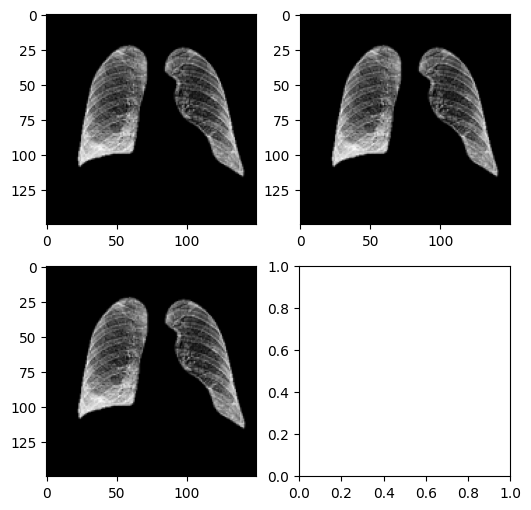

total steps: 926
epochs: 40
Training Starting...

Starting epoch: 1


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [17]:
#* hyperparameters
size = 150
batch_size = 16
num_classes = 4
use_from_total = 1
seed_ = 41
USE_MASKS = True
patience = 5
use_val = True
use_early_stopping = True
learning_rate = 0.0001 
weight_decay_ = 0.001
num_epochs = 40

model = CNN_DenseNet(pretrained=True)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay_)

train_loader, val_loader, test_loader, idx_to_class = load_dataset()

epoch_train_loss, epoch_val_loss = train(model,optimizer,loss_fn,num_epochs)
aac,_,_ = test_accuracy(model)
write_results(model, epoch_train_loss, epoch_val_loss)

### 8) Model densenet121, no mask, no val - 94.4% accuracy

In [22]:
#* hyperparameters
size = 150
batch_size = 16
num_classes = 4
use_from_total = 1
seed_ = 41
USE_MASKS = False
patience = 5
use_val = False
use_early_stopping = False
learning_rate = 0.0001 
weight_decay_ = 0.001
num_epochs = 40

model = CNN_DenseNet(pretrained=True)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay_)

train_loader, val_loader, test_loader, idx_to_class = load_dataset()

epoch_train_loss, epoch_val_loss = train(model,optimizer,loss_fn,num_epochs)
aac,_,_ = test_accuracy(model)
write_results(model, epoch_train_loss, epoch_val_loss)

1024
Loading Dataset...


KeyboardInterrupt: 

### 9) Model densenet121, mask, no val - 90.5% accuracy

In [16]:
#* hyperparameters
size = 150
batch_size = 16
num_classes = 4
use_from_total = 1
seed_ = 41
USE_MASKS = True
patience = 5
use_val = False
use_early_stopping = False
learning_rate = 0.0001 
weight_decay_ = 0.001
num_epochs = 40

model = CNN_DenseNet(pretrained=True)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay_)

train_loader, val_loader, test_loader, idx_to_class = load_dataset()

epoch_train_loss, epoch_val_loss = train(model,optimizer,loss_fn,num_epochs)
aac,_,_ = test_accuracy(model)
write_results(model, epoch_train_loss, epoch_val_loss)

1024


KeyboardInterrupt: 

## Load Trained Models

### load by filename

In [42]:
# Load selected model 
def load_trained_model(selected_model, selected_model_path):
  # selected_model_path = "./modelDENSENET_91.pth"
  print('loading model before testing.')
  model_checkpoint = torch.load(selected_model_path)
  # selected_model = CNN_DenseNet(pretrained=True)
  selected_model.load_state_dict(model_checkpoint['state_dict'])
  return selected_model

### Model 0

Loading Dataset...
Dataset ImageFolder
    Number of datapoints: 21165
    Root location: ./COVID-19_Radiography_Dataset/dataset_images/
    StandardTransform
Transform: Compose(
               RandomAdjustSharpness(sharpness_factor=20,p=1)
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
               Grayscale(num_output_channels=3)
               ToTensor()
           )
<class 'torchvision.datasets.folder.ImageFolder'>
{0: 'COVID', 1: 'Lung_Opacity', 2: 'Normal', 3: 'Viral Pneumonia'}
Loaded Dataset!
train set size: 14814
val set size: 4232
test set size: 2119
Label: Lung_Opacity


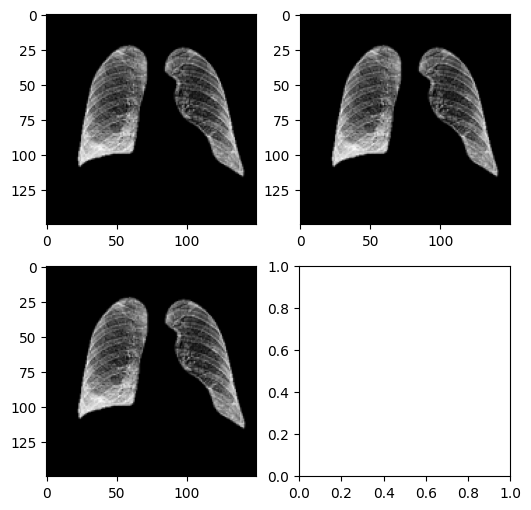

C:\Users\SSD\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


loading model before testing.

 Calculating current model accuracy
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Test Accuracy of the model: 85.70080226521944 %


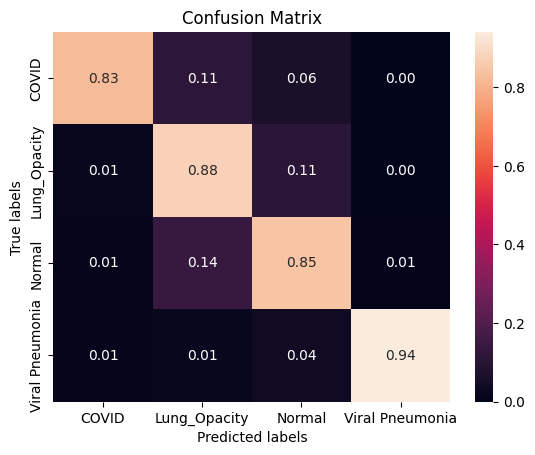

In [108]:
#* hyperparameters
size = 150
batch_size = 16
num_classes = 4
use_from_total = 1
seed_ = 41
USE_MASKS = False
patience = 5
use_val = True
use_early_stopping = False
learning_rate = 0.0001 
weight_decay_ = 0.001
num_epochs = 40

train_loader, val_loader, test_loader, idx_to_class = load_dataset()

model = CNN_Simple(num_classes).to(device)
model = load_trained_model(model, "./models/early_stop_comparison/simplecnn_nomask_val_noearlystop/SimpleCNN_0.pth")
aac, test_labs, pred_labs = test_accuracy(model)
plot_cnf_matrix(test_labs, pred_labs)

### Model 1

Loading Dataset...
Dataset ImageFolder
    Number of datapoints: 21165
    Root location: ./COVID-19_Radiography_Dataset/dataset_images/
    StandardTransform
Transform: Compose(
               RandomAdjustSharpness(sharpness_factor=20,p=1)
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
               Grayscale(num_output_channels=3)
               ToTensor()
           )
<class 'torchvision.datasets.folder.ImageFolder'>
{0: 'COVID', 1: 'Lung_Opacity', 2: 'Normal', 3: 'Viral Pneumonia'}
Loaded Dataset!
train set size: 14814
val set size: 4232
test set size: 2119
Label: Lung_Opacity


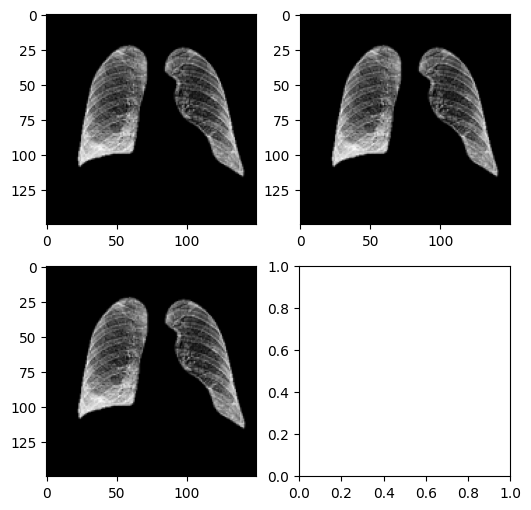

C:\Users\SSD\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


loading model before testing.

 Calculating current model accuracy
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Test Accuracy of the model: 87.06937234544597 %


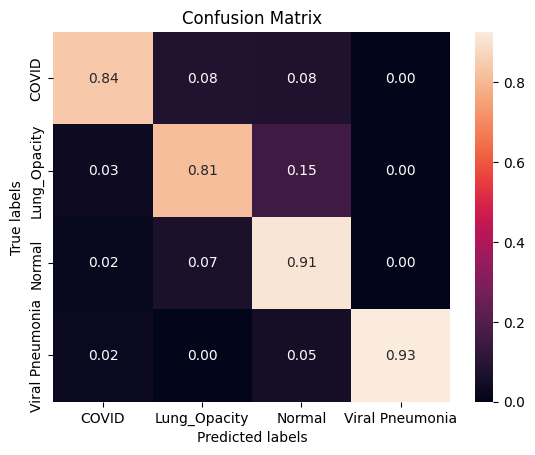

In [109]:
#* hyperparameters
size = 150
batch_size = 16
num_classes = 4
use_from_total = 1
seed_ = 41
USE_MASKS = False
patience = 5
use_val = True
use_early_stopping = True
learning_rate = 0.0001 
weight_decay_ = 0.001
num_epochs = 40

train_loader, val_loader, test_loader, idx_to_class = load_dataset()

model = CNN_Simple(num_classes).to(device)
model = load_trained_model(model, "./models/simplecnn_models/simplecnn_nomask_val/SimpleCNN_0.pth")
aac, test_labs, pred_labs = test_accuracy(model)
plot_cnf_matrix(test_labs, pred_labs)

### Model 2

Loading Dataset...
Dataset ImageFolder
    Number of datapoints: 21165
    Root location: ./COVID-19_Radiography_Dataset/dataset_images/
    StandardTransform
Transform: Compose(
               RandomAdjustSharpness(sharpness_factor=20,p=1)
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
               Grayscale(num_output_channels=3)
               ToTensor()
           )
<class 'torchvision.datasets.folder.ImageFolder'>
{0: 'COVID', 1: 'Lung_Opacity', 2: 'Normal', 3: 'Viral Pneumonia'}
Loaded Dataset!
train set size: 14814
val set size: 4232
test set size: 2119
Label: Lung_Opacity


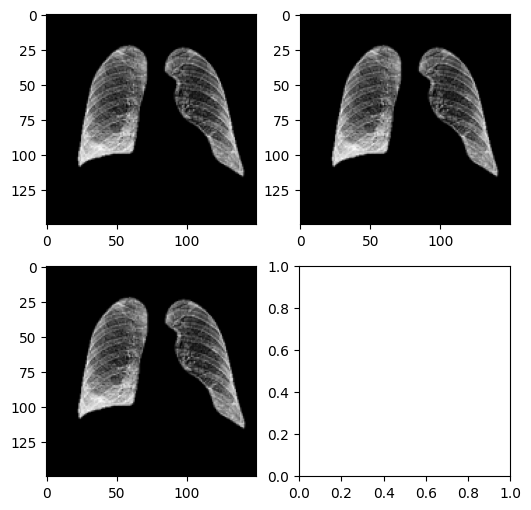

C:\Users\SSD\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


loading model before testing.

 Calculating current model accuracy
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Test Accuracy of the model: 81.12317130722039 %


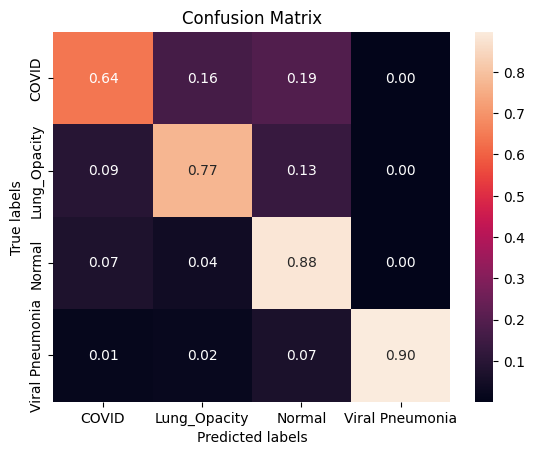

In [111]:
#* hyperparameters
size = 150
batch_size = 16
num_classes = 4
use_from_total = 1
seed_ = 41
USE_MASKS = True
patience = 5
use_val = True
use_early_stopping = True
learning_rate = 0.0001 
weight_decay_ = 0.001
num_epochs = 40

train_loader, val_loader, test_loader, idx_to_class = load_dataset()

model = CNN_Simple(num_classes).to(device)
model = load_trained_model(model, "./models/simplecnn_models/simplecnn_mask_val/SimpleCNN_1.pth")
aac, test_labs, pred_labs = test_accuracy(model)
plot_cnf_matrix(test_labs, pred_labs)


### Model 3

Loading Dataset...
Dataset ImageFolder
    Number of datapoints: 21165
    Root location: ./COVID-19_Radiography_Dataset/dataset_images/
    StandardTransform
Transform: Compose(
               RandomAdjustSharpness(sharpness_factor=20,p=1)
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
               Grayscale(num_output_channels=3)
               ToTensor()
           )
<class 'torchvision.datasets.folder.ImageFolder'>
{0: 'COVID', 1: 'Lung_Opacity', 2: 'Normal', 3: 'Viral Pneumonia'}
Loaded Dataset!
train set size: 14814
val set size: 4232
test set size: 2119
Label: Lung_Opacity


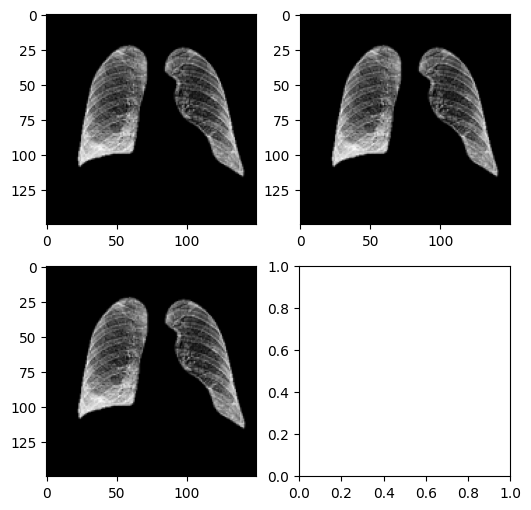

C:\Users\SSD\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


loading model before testing.

 Calculating current model accuracy
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Test Accuracy of the model: 85.79518640868334 %


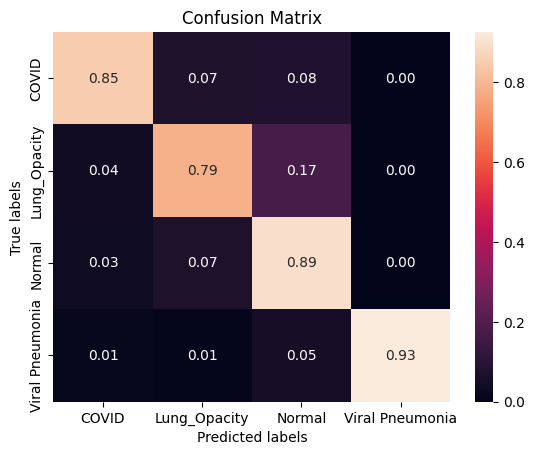

In [126]:
#* hyperparameters
size = 150
batch_size = 16
num_classes = 4
use_from_total = 1
seed_ = 41
USE_MASKS = False
patience = 5
use_val = True
use_early_stopping = True
learning_rate = 0.0001 
weight_decay_ = 0.001
num_epochs = 40

train_loader, val_loader, test_loader, idx_to_class = load_dataset()

model = CNN_Simple_BatchNorm(num_classes).to(device)
model = load_trained_model(model, "./models/batch_dropout_comparison/simplecnn_batchnorm_all/SimpleCNN_BatchNorm_0.pth")
aac, test_labs, pred_labs = test_accuracy(model)
plot_cnf_matrix(test_labs, pred_labs)

### Model 4

Loading Dataset...
Dataset ImageFolder
    Number of datapoints: 21165
    Root location: ./COVID-19_Radiography_Dataset/dataset_images/
    StandardTransform
Transform: Compose(
               RandomAdjustSharpness(sharpness_factor=20,p=1)
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
               Grayscale(num_output_channels=3)
               ToTensor()
           )
<class 'torchvision.datasets.folder.ImageFolder'>
{0: 'COVID', 1: 'Lung_Opacity', 2: 'Normal', 3: 'Viral Pneumonia'}
Loaded Dataset!
train set size: 14814
val set size: 4232
test set size: 2119
Label: Lung_Opacity


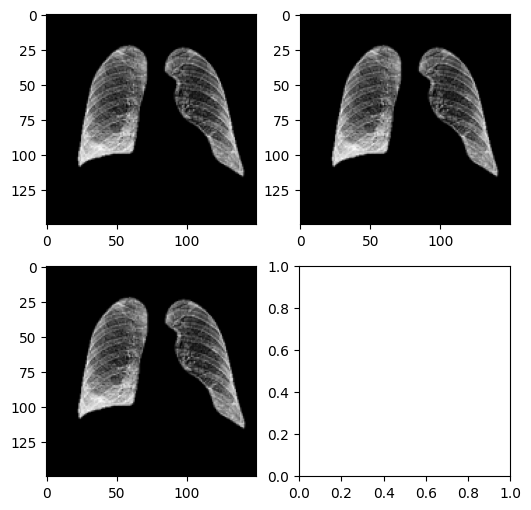

C:\Users\SSD\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


loading model before testing.

 Calculating current model accuracy
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Test Accuracy of the model: 87.06937234544597 %


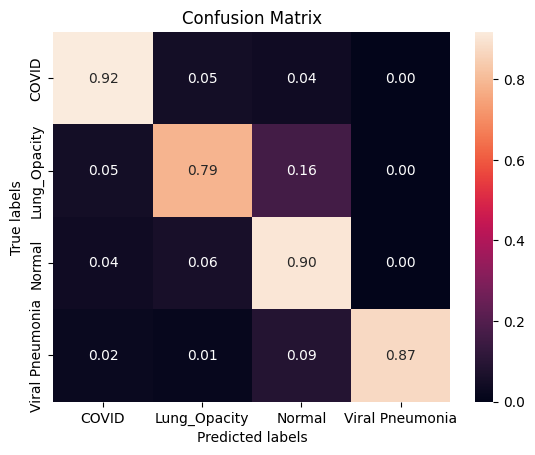

In [124]:
#* hyperparameters
size = 150
batch_size = 16
num_classes = 4
use_from_total = 1
seed_ = 41
USE_MASKS = False
patience = 5
use_val = True
use_early_stopping = True
learning_rate = 0.0001 
weight_decay_ = 0.001
num_epochs = 40

train_loader, val_loader, test_loader, idx_to_class = load_dataset()

model = CNN_Simple_BatchNorm_Dropout(num_classes).to(device)
model = load_trained_model(model, "./models/batch_dropout_comparison/simplecnn_batchnorm_dropout_all/SimpleCNN_BatchNorm_Dropout_0.pth")
aac, test_labs, pred_labs = test_accuracy(model)
plot_cnf_matrix(test_labs, pred_labs)

### Model 5

Loading Dataset...
Dataset ImageFolder
    Number of datapoints: 21165
    Root location: ./COVID-19_Radiography_Dataset/dataset_images/
    StandardTransform
Transform: Compose(
               RandomAdjustSharpness(sharpness_factor=20,p=1)
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
               Grayscale(num_output_channels=3)
               ToTensor()
           )
<class 'torchvision.datasets.folder.ImageFolder'>
{0: 'COVID', 1: 'Lung_Opacity', 2: 'Normal', 3: 'Viral Pneumonia'}
Loaded Dataset!
train set size: 14814
val set size: 4232
test set size: 2119
Label: Lung_Opacity


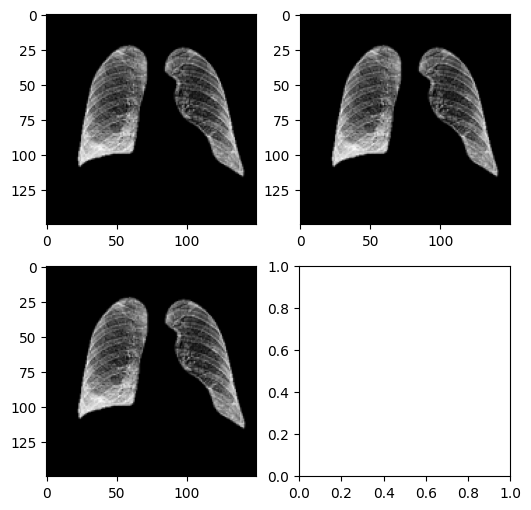

loading model before testing.

 Calculating current model accuracy
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Test Accuracy of the model: 85.93676262387919 %


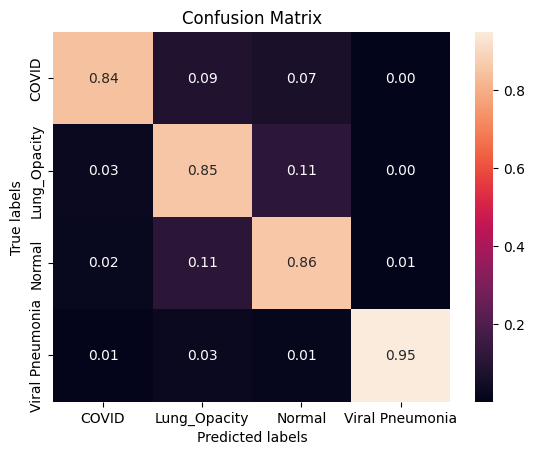

In [123]:
#* hyperparameters
size = 150
batch_size = 16
num_classes = 4
use_from_total = 1
seed_ = 41
USE_MASKS = False
patience = 5
use_val = True
use_early_stopping = True
learning_rate = 0.0001 
weight_decay_ = 0.001
num_epochs = 40

train_loader, val_loader, test_loader, idx_to_class = load_dataset()

model = CNN_Simple_BatchNorm_Dropout_First(num_classes).to(device)
model = load_trained_model(model, "./models/batch_dropout_comparison/simplecnn_batchnorm_dropout_first/SimpleCNN_BatchNorm_Dropout_First_0.pth")
aac, test_labs, pred_labs = test_accuracy(model)
plot_cnf_matrix(test_labs, pred_labs)

### Model 6

Loading Dataset...
Dataset ImageFolder
    Number of datapoints: 21165
    Root location: ./COVID-19_Radiography_Dataset/dataset_images/
    StandardTransform
Transform: Compose(
               RandomAdjustSharpness(sharpness_factor=20,p=1)
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
               Grayscale(num_output_channels=3)
               ToTensor()
           )
<class 'torchvision.datasets.folder.ImageFolder'>
{0: 'COVID', 1: 'Lung_Opacity', 2: 'Normal', 3: 'Viral Pneumonia'}
Loaded Dataset!
train set size: 14814
val set size: 4232
test set size: 2119
Label: Lung_Opacity


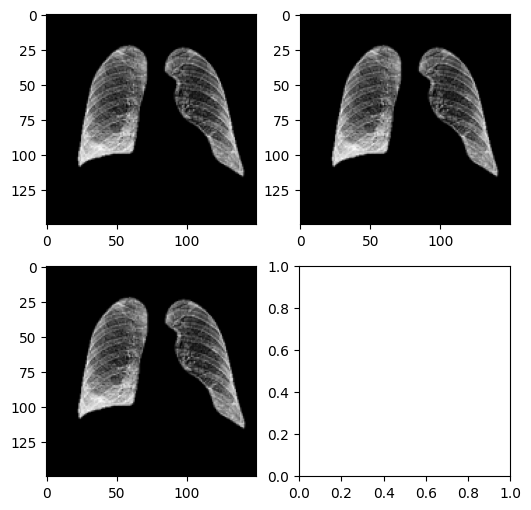

1024
loading model before testing.

 Calculating current model accuracy
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Test Accuracy of the model: 93.58187824445493 %


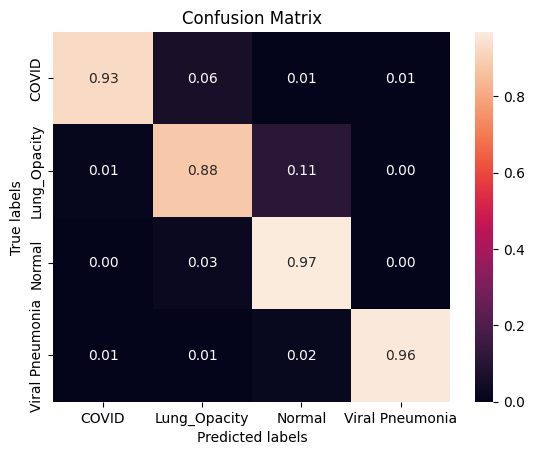

In [113]:
#* hyperparameters
size = 150
batch_size = 16
num_classes = 4
use_from_total = 1
seed_ = 41
USE_MASKS = False
patience = 5
use_val = True
use_early_stopping = True
learning_rate = 0.0001 
weight_decay_ = 0.001
num_epochs = 40

train_loader, val_loader, test_loader, idx_to_class = load_dataset()

model = CNN_DenseNet(pretrained=True)
model = load_trained_model(model, "./models/densenet_models/densenet_nomask_val/model_1.pth")
aac, test_labs, pred_labs = test_accuracy(model)
plot_cnf_matrix(test_labs, pred_labs)

### Model 7

Loading Dataset...
Dataset ImageFolder
    Number of datapoints: 21165
    Root location: ./COVID-19_Radiography_Dataset/dataset_images/
    StandardTransform
Transform: Compose(
               RandomAdjustSharpness(sharpness_factor=20,p=1)
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
               Grayscale(num_output_channels=3)
               ToTensor()
           )
<class 'torchvision.datasets.folder.ImageFolder'>
{0: 'COVID', 1: 'Lung_Opacity', 2: 'Normal', 3: 'Viral Pneumonia'}
Loaded Dataset!
train set size: 14814
val set size: 4232
test set size: 2119
Label: Lung_Opacity


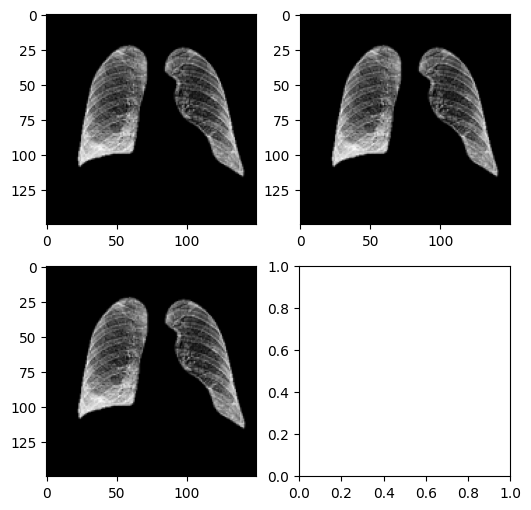

1024
loading model before testing.

 Calculating current model accuracy
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Test Accuracy of the model: 89.24020764511562 %


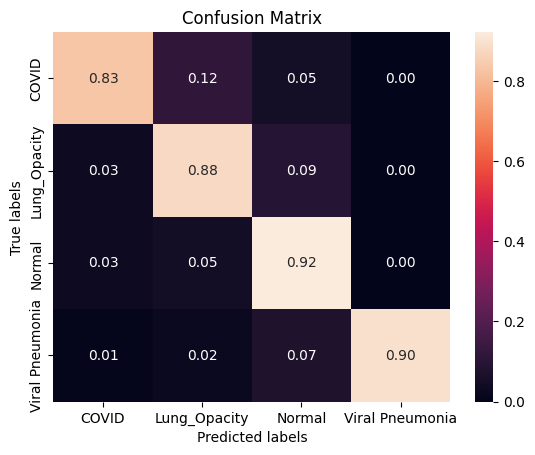

In [114]:
#* hyperparameters
size = 150
batch_size = 16
num_classes = 4
use_from_total = 1
seed_ = 41
USE_MASKS = True
patience = 5
use_val = True
use_early_stopping = True
learning_rate = 0.0001 
weight_decay_ = 0.001
num_epochs = 40

train_loader, val_loader, test_loader, idx_to_class = load_dataset()

model = CNN_DenseNet(pretrained=True)
model = load_trained_model(model, "./models/densenet_models/densenet_mask_val/model_2.pth")
aac, test_labs, pred_labs = test_accuracy(model)
plot_cnf_matrix(test_labs, pred_labs)

### Model 8

Loading Dataset...
Dataset ImageFolder
    Number of datapoints: 21165
    Root location: ./COVID-19_Radiography_Dataset/dataset_images/
    StandardTransform
Transform: Compose(
               RandomAdjustSharpness(sharpness_factor=20,p=1)
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
               Grayscale(num_output_channels=3)
               ToTensor()
           )
<class 'torchvision.datasets.folder.ImageFolder'>
{0: 'COVID', 1: 'Lung_Opacity', 2: 'Normal', 3: 'Viral Pneumonia'}
Loaded Dataset!
train set size: 14814
val set size: 1
test set size: 6351
Label: Lung_Opacity


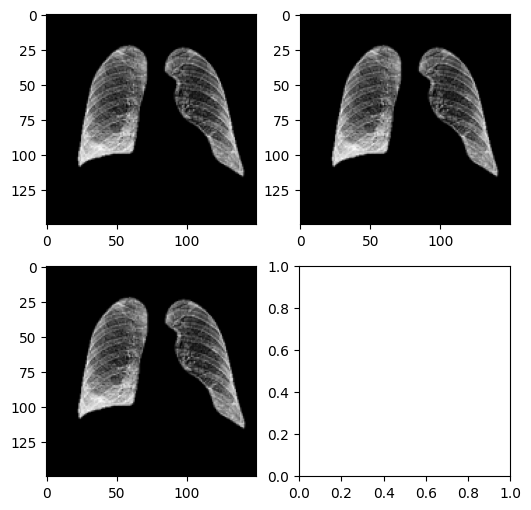

1024
loading model before testing.

 Calculating current model accuracy
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Test Accuracy of the model: 94.36309242638954 %


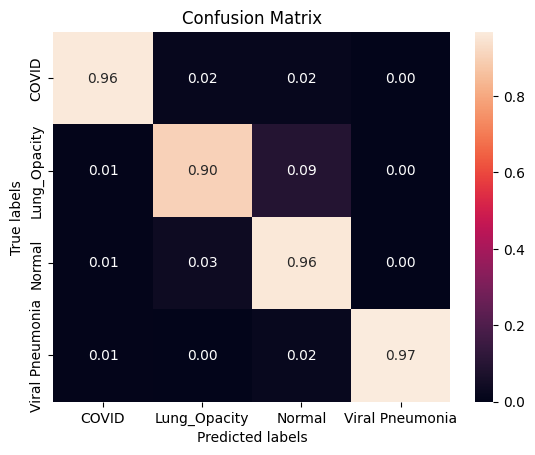

In [115]:
#* hyperparameters
size = 150
batch_size = 16
num_classes = 4
use_from_total = 1
seed_ = 41
USE_MASKS = False
patience = 5
use_val = False
use_early_stopping = False
learning_rate = 0.0001 
weight_decay_ = 0.001
num_epochs = 40

train_loader, val_loader, test_loader, idx_to_class = load_dataset()

model = CNN_DenseNet(pretrained=True)
model = load_trained_model(model, "./models/densenet_models/densenet_nomask_noval/model_8.pth")
aac, test_labs, pred_labs = test_accuracy(model)
plot_cnf_matrix(test_labs, pred_labs)

### Model 9

Loading Dataset...
Dataset ImageFolder
    Number of datapoints: 21165
    Root location: ./COVID-19_Radiography_Dataset/dataset_images/
    StandardTransform
Transform: Compose(
               RandomAdjustSharpness(sharpness_factor=20,p=1)
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
               Grayscale(num_output_channels=3)
               ToTensor()
           )
<class 'torchvision.datasets.folder.ImageFolder'>
{0: 'COVID', 1: 'Lung_Opacity', 2: 'Normal', 3: 'Viral Pneumonia'}
Loaded Dataset!
train set size: 14814
val set size: 1
test set size: 6351
Label: Lung_Opacity


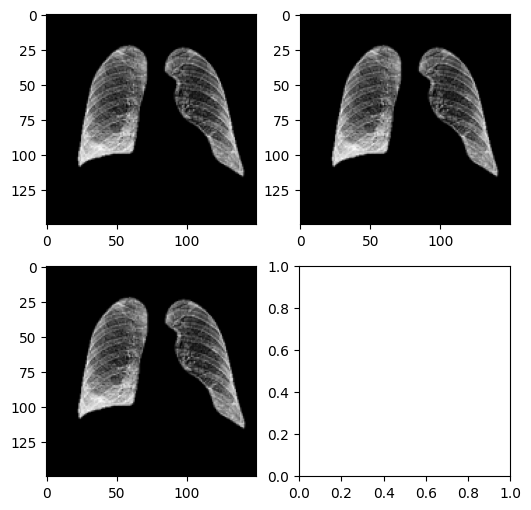

1024
loading model before testing.

 Calculating current model accuracy
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Test Accuracy of the model: 90.50543221539915 %


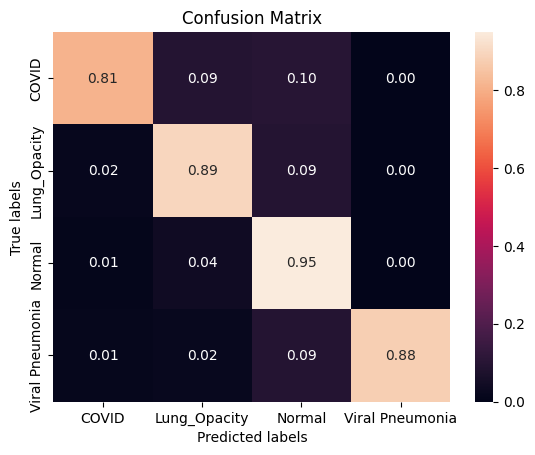

In [116]:
#* hyperparameters
size = 150
batch_size = 16
num_classes = 4
use_from_total = 1
seed_ = 41
USE_MASKS = True
patience = 5
use_val = False
use_early_stopping = False
learning_rate = 0.0001 
weight_decay_ = 0.001
num_epochs = 40

train_loader, val_loader, test_loader, idx_to_class = load_dataset()

model = CNN_DenseNet(pretrained=True)
model = load_trained_model(model, "./models/densenet_models/densenet_mask_noval/model_9.pth")
aac, test_labs, pred_labs = test_accuracy(model)
plot_cnf_matrix(test_labs, pred_labs)

## Visualize Model

In [151]:
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

Label: 0


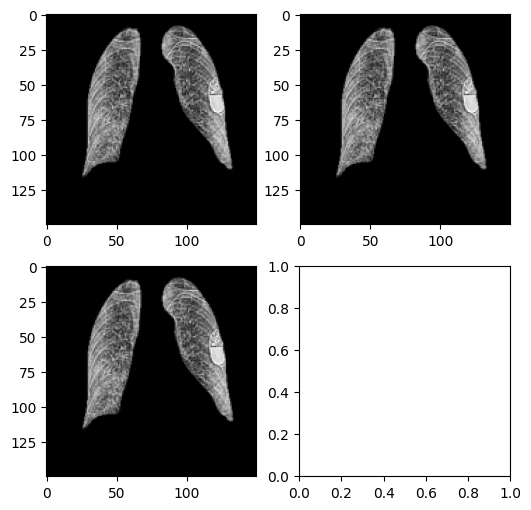

output: tensor([[-1.6556,  0.7483,  1.8760, -4.0152]])
image label: COVID
predicted label: Normal


In [181]:
def Show(out, title = ''):
  print(title)
  out = out.permute(1,0,2,3)
  grilla = torchvision.utils.make_grid(out)
  plt.imshow(transforms.ToPILImage()(grilla), 'jet')
  plt.show()

def Show_Weight(out, title = ''):
  print(title)
  grilla = torchvision.utils.make_grid(out)
  plt.imshow(transforms.ToPILImage()(grilla), 'jet')
  plt.show()


# with torch.no_grad():
#   model.to('cpu')
#   test_id = 10

#   img, label = test_set[test_id] 
#   if USE_MASKS:
#     img = img * test_set_mask[test_id][0] # apply mask
#   Show_imgs(img, str(label))
#   img = img.unsqueeze(0)
#   out = model(img)
#   print("output:", out)
#   # print ((out == out.max()).nonzero())
#   _, predicted = torch.max(out.data, 1)
#   print("image label:", idx_to_class[label])
#   print("predicted label:", idx_to_class[predicted[0].item()])
  
#   model.to(device)

  

## Extra

In [34]:
print('current memory allocated: {}'.format(torch.cuda.memory_allocated() / 1024 ** 2))
print('max memory allocated: {}'.format(torch.cuda.max_memory_allocated() / 1024 ** 2))
print('cached memory: {}'.format(torch.cuda.memory_cached() / 1024 ** 2))

current memory allocated: 46.31298828125
max memory allocated: 967.80029296875
cached memory: 1930.0


C:\Users\SSD\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\cuda\memory.py:395: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


X
torch.Size([1, 1, 200, 200])
Y
torch.Size([1, 1, 198, 198])
Entrada
torch.Size([1, 1, 200, 200])
torch.Size([1, 1, 200, 200])


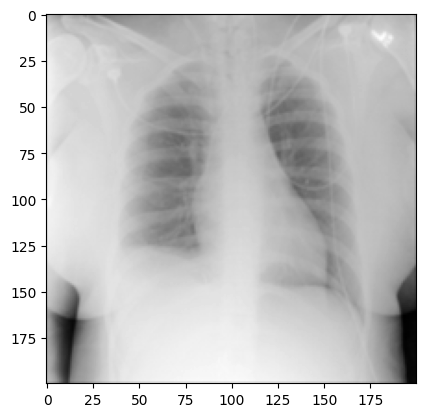

In [ ]:
img, label = train_set[564]
plt.imshow(transforms.ToPILImage()(img), cmap = 'gray')
img = img.unsqueeze(0)

conv = nn.Conv2d(in_channels=1,out_channels=1, kernel_size=5, stride=1, padding=1)
out = conv(img)

print("X")
print(img.shape)
print("Y")
print(out.shape)

conv2 = nn.Conv2d(in_channels=1,out_channels=1, kernel_size=3, stride=1, padding=1)
conv3 = nn.Conv2d(in_channels=1,out_channels=1, kernel_size=3, stride=1, padding=1)
out = conv2(img)
out = conv3(out)


print("Entrada")
print(img.shape)

print(out.shape)



In [ ]:
print([ e.shape  for e in model.fc.parameters()])

model.fc.weight


AttributeError: 'CNN' object has no attribute 'fc'